In [108]:
using Revise
using Bilevel: contact_jacobian!, contact_friction_τ_direct!, contact_normal_τ_direct!

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat

using ForwardDiff
using DiffResults
using LinearAlgebra
using StaticArrays
using Plots
using BenchmarkTools
using Profile
using ProfileView

In [158]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.125)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: ball, Edge: floor_to_ball
No non-tree joints., ball, Point3D in "after_floor_to_ball": [0.0, 0.0, 0.0], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.125, false))])

In [159]:
N = 10
Δt = 0.1
q0 = [1., 0., 0., 0., 0., 0., 0.]
v0 = [0., 0., 0., 5., 0., 0.]

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, -6.657e-17, -8.88178e-17, 0.389638, 0.0, 0.0], [1.0, 0.0, -6.66134e-17, -8.88178e-17, 0.668913, 0.0, 0.0], [1.0, 0.0, -6.66134e-17, -8.88178e-17, 0.837825, 0.0, 0.0], [1.0, 0.0, -6.66134e-17, -8.88178e-17, 0.896375, 0.0, 0.0], [1.0, 0.0, -6.66134e-17, 2.01006e-17, 0.896375, 7.01661e-19, 4.33614e-11], [1.0, 0.0, 3.70294e-10, -1.65076e-17, 0.896375, 0.0, 0.0], [1.0, 0.0, 3.70294e-10, -1.65076e-17, 0.896375, 0.0, 0.0], [1.0, 0.0, 3.70294e-10, -1.65076e-17, 0.896375, 0.0, 0.0], [1.0, 0.0, 3.70294e-10, -1.65076e-17, 0.896375, 0.0, 0.0]], Array{Float64,1}[[0.0, 0.0, 0.0, 5.0, 0.0, 0.0], [0.0, -1.33227e-15, 0.0, 3.89637, 0.0, -5.18764e-16], [0.0, -1.33227e-15, 0.0, 2.79275, 0.0, -3.72165e-16], [0.0, -1.33227e-15, 0.0, 1.68913, 0.0, -2.24941e-16], [0.0, -1.33227e-15, 0.0, 0.5855, 0.0, -7.80998e-17], [0.0, -1.33227e-15, 0.0, 0.0, -1.65211e-17, 4.33615e-10], [0.0, -1.33227e-15, 0.0, -3.2113e-19, 1.65211e-17, 4.33615e-10], [0.0, -1

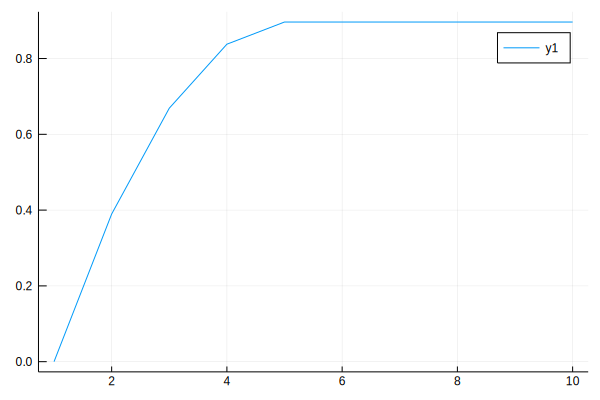

In [163]:
plot(traj[7][5,:])

In [161]:
traj[4]

10-element Array{Array{Array{Float64,1},1},1}:
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]                
 [[1.0, 0.0, 0.0, 1.125, 0.0, 3.89638]]          
 [[1.0, 0.0, 0.0, 1.125, 0.0, 2.79275]]          
 [[1.0, 0.0, 0.0, 1.125, 0.0, 1.68913]]          
 [[1.0, 0.0, 0.0, 1.125, 0.0, 0.5855]]           
 [[1.0, 0.0, 0.0, 0.59684, 0.0, 0.0]]            
 [[1.0, 0.29842, 0.0, 0.29842, 0.0, 1.29247e-26]]
 [[1.0, 0.29842, 0.0, 0.29842, 0.0, 1.29247e-26]]
 [[1.0, 0.29842, 0.0, 0.29842, 0.0, 1.29247e-26]]
 [[1.0, 0.29842, 0.0, 0.29842, 0.0, 1.29247e-26]]

In [165]:
bias_traj = Array{Array{Float64,1},1}()

for n = 1:N-1
    q0 = traj[1][n]
    v0 = traj[2][n]
    u0 = zeros(num_vel)
    h = traj[6][n+1] - traj[6][n]
    qnext = traj[1][n+1]
    vnext = traj[2][n+1]
    
    x0 = sim_data.state_cache[1][Float64]
    xn = sim_data.state_cache[2][Float64]
    envj = sim_data.envj_cache[2][Float64]

    set_configuration!(x0, q0)
    set_velocity!(x0, v0)
    setdirty!(x0)
    set_configuration!(xn, qnext)
    set_velocity!(xn, vnext)
    setdirty!(xn)

    normalize_configuration!(x0)
    normalize_configuration!(xn)

    H = mass_matrix(x0)
    Hi = inv(H)
    config_derivative = configuration_derivative(xn)
    dyn_bias = dynamics_bias(xn)
    
    contact_bias = u0 .- dyn_bias .- (1. / Δt)*H*(vnext - v0)
    
    push!(bias_traj, contact_bias)
end

bias_traj

9-element Array{Array{Float64,1},1}:
 [-9.86076e-32, 1.33227e-15, -1.64215e-47, 11.0362, -1.16005e-31, -9.81]
 [0.0, 0.0, -3.28429e-47, 11.0362, -1.16081e-31, -9.81]                 
 [-1.97215e-31, 0.0, -1.09476e-47, 11.0362, -1.16081e-31, -9.81]        
 [-1.97215e-31, 0.0, 0.0, 11.0362, -1.16081e-31, -9.81]                 
 [4.93038e-32, 0.0, 0.0, 5.855, 1.65211e-16, -9.81]                     
 [-1.28011e-60, -7.78997e-60, 0.0, 7.26517e-9, -3.30423e-16, -9.81]     
 [0.0, 0.0, 0.0, 7.26517e-9, 1.1993e-25, -9.81]                         
 [0.0, 0.0, 0.0, 7.26517e-9, 1.1993e-25, -9.81]                         
 [0.0, 0.0, 0.0, 7.26517e-9, 1.1993e-25, -9.81]                         

# semidirect

In [106]:
sim_data = get_sim_data_direct(mechanism,env,Δt)
num_contacts = length(sim_data.env.contacts)
num_vel = num_velocities(mechanism)

sim_data.fric_options[1]["num_fosteps"] = 0
sim_data.fric_options[1]["num_sosteps"] = 5
sim_data.fric_options[1]["c"] = 1
sim_data.fric_options[1]["c_fos"] = 1
sim_data.fric_options[1]["c_sos"] = 1

for n = 1:N-1
    q0 = traj[1][n]
    v0 = traj[2][n]
    u0 = zeros(num_vel)
    h = traj[6][n+1] - traj[6][n]
    qnext = traj[1][n+1]
    vnext = traj[2][n+1]

    nvs = sim_data.normal_vs[1]
    x_normal = zeros(nvs.num_vars)
    for i = 1:num_contacts
        x_normal[nvs(Symbol("c_n", i))] = [traj[4][n+1][i][1]]
    end
    
    x0 = sim_data.state_cache[1][Float64]
    xn = sim_data.state_cache[2][Float64]
    envj = sim_data.envj_cache[2][Float64]

    set_configuration!(x0, q0)
    set_velocity!(x0, v0)
    setdirty!(x0)
    set_configuration!(xn, qnext)
    set_velocity!(xn, vnext)
    setdirty!(xn)

    normalize_configuration!(x0)
    normalize_configuration!(xn)

    H = mass_matrix(x0)
    Hi = inv(H)
    config_derivative = configuration_derivative(xn)
    dyn_bias = dynamics_bias(xn)

    contact_jacobian!(envj, xn)
    contact_bias = Vector{Float64}(undef, num_vel)
    if (num_contacts > 0)
        # compute friction forces
        contact_friction_τ_direct!(contact_bias, sim_data, Hi, envj, dyn_bias, u0, v0, Array{Float64,1}(), x_normal, 1)
    
        display(contact_bias)
    end
end

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  9.809999999999961    
 -8.392800334951622e-15
 -9.81                 

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
  9.809999999999963     
 -1.8604897180183867e-14
 -9.81                  

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  9.809999999994778    
  1.441236342702233e-14
 -9.809999999999999    

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  9.809999999999995    
  6.092980987868551e-16
 -9.809999999999999    

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
 10.76000000000202      
  1.0246803405777882e-12
 -9.809999999999999     

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  0.9500000000000093   
  4.440892098500626e-16
 -9.809999999999997    

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
 -1.3563320722547928e-15
 -2.220446049250313e-16 
 -9.809999999999997     

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
 -1.1342874673297615e-15
  2.220446049250313e-16 
 -9.809999999999997     

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
 -1.1342874673297615e-15
  2.220446049250313e-16 
 -9.809999999999997     

# direct

In [115]:
sim_data = get_sim_data_direct(mechanism,env,Δt)
num_contacts = length(sim_data.env.contacts)
num_vel = num_velocities(mechanism)

sim_data.normal_options[1]["num_fosteps"] = 0
sim_data.normal_options[1]["num_sosteps"] = 5
sim_data.normal_options[1]["c"] = 1
sim_data.normal_options[1]["c_fos"] = 1
sim_data.normal_options[1]["c_sos"] = 1

sim_data.fric_options[1]["num_fosteps"] = 0
sim_data.fric_options[1]["num_sosteps"] = 5
sim_data.fric_options[1]["c"] = 1
sim_data.fric_options[1]["c_fos"] = 1
sim_data.fric_options[1]["c_sos"] = 1

for n = 1:N-1
    q0 = traj[1][n]
    v0 = traj[2][n]
    u0 = zeros(num_vel)
    h = traj[6][n+1] - traj[6][n]
    qnext = traj[1][n+1]
    vnext = traj[2][n+1]
    
    x0 = sim_data.state_cache[1][Float64]
    xn = sim_data.state_cache[2][Float64]
    envj = sim_data.envj_cache[2][Float64]

    set_configuration!(x0, q0)
    set_velocity!(x0, v0)
    setdirty!(x0)
    set_configuration!(xn, qnext)
    set_velocity!(xn, vnext)
    setdirty!(xn)

    normalize_configuration!(x0)
    normalize_configuration!(xn)

    H = mass_matrix(x0)
    Hi = inv(H)
    config_derivative = configuration_derivative(xn)
    dyn_bias = dynamics_bias(xn)

    contact_jacobian!(envj, xn)
    normal_bias = Vector{Float64}(undef, num_vel)
    contact_bias = Vector{Float64}(undef, num_vel)
    if (num_contacts > 0)
        # compute the normal forces
        x_normal = contact_normal_τ_direct!(normal_bias, sim_data, Hi, envj, dyn_bias, u0, v0, Array{Float64,1}(), 1)
        
        # compute friction forces
        contact_friction_τ_direct!(contact_bias, sim_data, Hi, envj, dyn_bias, u0, v0, Array{Float64,1}(), x_normal, 1)
    
        display(contact_bias)
    end
end

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
  9.810000000000008     
 -1.2811230876573432e-14
 -9.810000000000073     

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  9.810000000000137    
  3.214875610728092e-14
 -9.81000000000009     

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
  9.809999999995036     
 -3.3782438949083186e-14
 -9.81000000000009      

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  9.810000000000048    
  4.731570003921971e-16
 -9.810000000000072    

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
 10.760000000001517    
 -8.179568133925841e-14
 -9.810000000000072    

6-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0                  
  0.9500000000000096   
 -2.220446049250313e-16
 -9.810000000000038    

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
 -1.2577997788193175e-15
  0.0                   
 -9.81000000000007      

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
 -1.2577997788193175e-15
  0.0                   
 -9.81000000000007      

6-element Array{Float64,1}:
  0.0                   
  0.0                   
  0.0                   
 -1.2577997788193175e-15
  0.0                   
 -9.81000000000007      

# estimation

In [151]:
function generate_solver_fn_estimation_direct()
    sim_data = get_sim_data_direct(mechanism,env,Δt)
    num_contacts = length(sim_data.env.contacts)
    num_vel = num_velocities(mechanism)
    
    sim_data.normal_options[1]["num_fosteps"] = 0
    sim_data.normal_options[1]["num_sosteps"] = 10
    sim_data.normal_options[1]["c"] = 1
    sim_data.normal_options[1]["c_fos"] = 1
    sim_data.normal_options[1]["c_sos"] = 1

    sim_data.fric_options[1]["num_fosteps"] = 0
    sim_data.fric_options[1]["num_sosteps"] = 10
    sim_data.fric_options[1]["c"] = 1
    sim_data.fric_options[1]["c_fos"] = 1
    sim_data.fric_options[1]["c_sos"] = 1
    
    function eval_obj(params::AbstractArray{T}) where T
        # set the friction coefficient for the floor
        obstacles[1].μ = params[1]
        
        # evaluate the dynamics residual on each datapoint as an inner problem
        losses = Array{T,1}(undef, N-1)
        for n = 1:N-1
            q0 = traj[1][n]
            v0 = traj[2][n]
            u0 = zeros(num_vel)
            h = traj[6][n+1] - traj[6][n]
            qnext = traj[1][n+1]
            vnext = traj[2][n+1]

            x0 = sim_data.state_cache[1][Float64]
            xn = sim_data.state_cache[2][Float64]
            envj = sim_data.envj_cache[2][Float64]

            set_configuration!(x0, q0)
            set_velocity!(x0, v0)
            setdirty!(x0)
            set_configuration!(xn, qnext)
            set_velocity!(xn, vnext)
            setdirty!(xn)

            normalize_configuration!(x0)
            normalize_configuration!(xn)

            H = mass_matrix(x0)
            Hi = inv(H)
            config_derivative = configuration_derivative(xn)
            dyn_bias = dynamics_bias(xn)

            contact_jacobian!(envj, xn)
            normal_bias = Vector{T}(undef, num_vel)
            contact_bias = Vector{T}(undef, num_vel)

            x_normal = contact_normal_τ_direct!(normal_bias, sim_data, Hi, envj, dyn_bias, u0, v0, params, 1)
            contact_friction_τ_direct!(contact_bias, sim_data, Hi, envj, dyn_bias, u0, v0, params, x_normal, 1)
        
            err = contact_bias - bias_traj[n]
            loss = err'*err
            
            losses[n] = loss
        end
        
        # add losses
        sum(losses)
    end

    function eval_cons(params::AbstractArray{T}) where T        
        # friction coeffs are positive
#         g = Vector{T}(undef, cs.num_eqs + cs.num_ineqs)
#         μ = params[1]
#         g[cs(:μ_pos)] .= 1e-5 - μ
        g = -params
        
        g
    end
    
    return Bilevel.generate_autodiff_solver_fn(eval_obj,eval_cons,[],1:1,1,hessian=false)
end

generate_solver_fn_estimation_direct (generic function with 2 methods)

In [156]:
solver_fn = generate_solver_fn_estimation_direct()

μ0 = [0.0001]
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6

1.0e-6

In [153]:
display(solver_fn([.2]))
display(solver_fn([.5]))
display(solver_fn([.75]))
display(solver_fn([1.]))
display(solver_fn([1.25]))
display(solver_fn([1.5]))
display(solver_fn([2.]))

(307.9555200256815, Float64[], [-0.2], [-769.889], Array{Float64}(0,1), [-1.0], [0.0])

(120.29512501647021, Float64[], [-0.5], [-481.18], Array{Float64}(0,1), [-1.0], [0.0])

(30.073789029838053, Float64[], [-0.75], [-240.59], Array{Float64}(0,1), [-1.0], [0.0])

(6.861143728017133e-23, Float64[], [-1.0], [-1.9092e-10], Array{Float64}(0,1), [-1.0], [0.0])

(24.961524992307393, Float64[], [-1.25], [192.472], Array{Float64}(0,1), [-1.0], [0.0])

(97.13859293784778, Float64[], [-1.5], [384.944], Array{Float64}(0,1), [-1.0], [0.0])

(385.84689915220133, Float64[], [-2.0], [769.889], Array{Float64}(0,1), [-1.0], [0.0])

In [157]:
μopt, info = Bilevel.snopt(solver_fn, 0, 1, μ0, options)

([1.0], "Finished successfully: optimality conditions satisfied")